## Sandwich_maps_local_coords_v2

Read DEMS and convert to rotated alongshore/cross-shore coordinate systems.
Modified to include some of the masked channels.

This produces the 1-m gridded 3D elevation map saved as an .nc file.

This version differs from the original because x is now the alongshore coordinate (positive to SE), and y is the alonshore ccoordinate (positive to NE). This happens after the maps have been interpolated.



In [1]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate, signal

import xarray as xr
%matplotlib inline

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
fdir = "D:/crs/proj/2015_Sandwich/2017_Karen_Sandwich_maps/"

#fdir = "C:/crs/proj/2017_Karen_Sandwich_maps"

fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed_channel_mask.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed_channel_mask.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif",\
#"2018-01-03_SandwichTNB_DEM_10cm_trimmed.tif",\ # needs to be padded...not very good control
"2018-01-10_SandwichTNB_DEM_10cm_trimmed.tif",\
#"DEM_10cm_selfcal_lokicampos_mid_denseNAD83UTM19.tif",\
"2018-03-09_SandwichTNB_PT_v2_DEM_10cm_trimmed.tif")

# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May_2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018",\
         "09-Mar-2018"])

nf=len(fnames)

In [3]:
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

### Make small box with local alongshore/cross-shore coordinates that will be our region of interest (ROI)

In [4]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
ymax = 280. # cross-shore
xmax = 1300.  # alongshore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

xcoords = np.linspace(0.5*dxy,xmax-0.5*dxy,nx)
ycoords = np.linspace(0.5*dxy,ymax-0.5*dxy,ny)
# Y is ascending
xrot, yrot=np.meshgrid(xcoords, ycoords ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(280, 1300)
[[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.2975e+03 1.2985e+03 1.2995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.2975e+03 1.2985e+03 1.2995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.2975e+03 1.2985e+03 1.2995e+03]
 ...
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.2975e+03 1.2985e+03 1.2995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.2975e+03 1.2985e+03 1.2995e+03]
 [5.0000e-01 1.5000e+00 2.5000e+00 ... 1.2975e+03 1.2985e+03 1.2995e+03]]
yrot:
(280, 1300)
[[  0.5   0.5   0.5 ...   0.5   0.5   0.5]
 [  1.5   1.5   1.5 ...   1.5   1.5   1.5]
 [  2.5   2.5   2.5 ...   2.5   2.5   2.5]
 ...
 [277.5 277.5 277.5 ... 277.5 277.5 277.5]
 [278.5 278.5 278.5 ... 278.5 278.5 278.5]
 [279.5 279.5 279.5 ... 279.5 279.5 279.5]]


### Convert ROI to UTM coordinates

Shape of xrot, yrot:  (280, 1300) (280, 1300)
Shape of xu and yu:  (280, 1300) (280, 1300)
Corners in rotated coordinates
Upper left [  0.5 279.5]  Upper right [1299.5  279.5]
Lower left [0.5 0.5]  Lower right [1.2995e+03 5.0000e-01]
Corners in UTM coordinates
Upper left [ 376418.75924416 4625460.38726746]  Upper right [ 377442.3852131  4624660.64301101]
Lower left [ 376246.98969254 4625240.5322672 ]  Lower right [ 377270.61566148 4624440.78801075]
Corners: 
[[ 376246.98969254 4625240.5322672 ]
 [ 377270.61566148 4624440.78801075]
 [ 377442.3852131  4624660.64301101]
 [ 376418.75924416 4625460.38726746]
 [ 376246.98969254 4625240.5322672 ]]


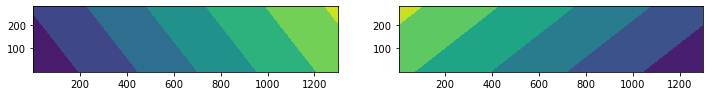

In [5]:
# Define the ROI with bottom left corner and rotation of axes
# original with origin in upper left
e0 = 377270.; n0 = 4624440.
rot = 52.

# _v2 with oring in bottom left
e0=376246.28785643
n0=4625240.44609256
rot=-38.

print('Shape of xrot, yrot: ',np.shape(xrot),np.shape(xrot))
shp = np.shape(xrot)
xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)
xu=np.reshape(xu,shp)
yu=np.reshape(yu,shp)
print('Shape of xu and yu: ',np.shape(xu),np.shape(yu))

# Corners in rotated coordinate system
LLr = np.asarray( [xrot[0][0],yrot[0][0]] )
LRr = np.asarray( [xrot[0][-1],yrot[0][-1]])
URr = np.asarray([xrot[-1][-1],yrot[-1][-1]])
ULr = np.asarray([xrot[-1][0],yrot[-1][0]])

# Corners in UTM coordinates
LLu = np.asarray( [xu[0][0],yu[0][0]] )
LRu = np.asarray( [xu[0][-1],yu[0][-1]])
URu = np.asarray([xu[-1][-1],yu[-1][-1]])
ULu = np.asarray([xu[-1][0],yu[-1][0]])

print('Corners in rotated coordinates')
print('Upper left',ULr,' Upper right',URr)
print('Lower left',LLr,' Lower right',LRr)
print('Corners in UTM coordinates')
print('Upper left',ULu,' Upper right',URu)
print('Lower left',LLu,' Lower right',LRu)

corners = np.asarray(  [LLu, LRu, URu, ULu, LLu ])
# [[xu[0][0],yu[0][0]],\
#                        [xu[0][-1],yu[0][-1]],\
#                        [xu[-1][-1],yu[-1][-1]],\
#                        [xu[-1][0],yu[-1][0]],\
#                        [xu[0][0],yu[0][0]]])

# write the UTM coords of the corners to an ASCII file
print("Corners: ")
print(corners)
fn = 'sandwich_corners.csv'
np.savetxt(fn, corners, delimiter=",")

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
plt.contourf(xrot,yrot,xu,5)
ax.set_aspect(1.)
ax = fig.add_subplot(1,2,2)
plt.contourf(xrot,yrot,yu,5)
ax.set_aspect(1.)

### Loop through the maps and interpolate onto the rotated coordinate system
Some of the DEMS have holes w/ NaNs.

Here is one option for smoothing the raw data before interpolating:
https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python

Strategy: Use a 2D convolution kernal that is sharp, but covers a 5x5 footprint. Using the

In [6]:
%%time
dslist=[]
ksize=3
for i in range(nf):
    fn = fdir+fnames[i]
    print(i, fn)
    
    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fn)
    
    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    
    # smooth with 2D running median
    zs = signal.medfilt2d(z, kernel_size=ksize)
    
    f = interpolate.RegularGridInterpolator( (y, x), zs, method='linear')   
    
    # Array for interpolated elevations
    zi=np.NaN*np.ones((ny,nx))

    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN
            
    da = xr.DataArray(zi,dims=['Cross-shore','Alongshore'],coords={'Cross-shore':ycoords, 'Alongshore': xcoords})
    # dslist.append(da.chunk()) # this does not work...can't concatenate a method
    da = da.chunk()
    dslist.append(da)

0 D:/crs/proj/2015_Sandwich/2017_Karen_Sandwich_maps/2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif
(10226,) (11987,) (1, 10226, 11987)
(11987,) (10226,) (10226, 11987)
1 D:/crs/proj/2015_Sandwich/2017_Karen_Sandwich_maps/2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif
(10156,) (11420,) (1, 10156, 11420)
(11420,) (10156,) (10156, 11420)
2 D:/crs/proj/2015_Sandwich/2017_Karen_Sandwich_maps/2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif
(10204,) (11673,) (1, 10204, 11673)
(11673,) (10204,) (10204, 11673)
3 D:/crs/proj/2015_Sandwich/2017_Karen_Sandwich_maps/2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif
(9858,) (11504,) (1, 9858, 11504)
(11504,) (9858,) (9858, 11504)
4 D:/crs/proj/2015_Sandwich/2017_Karen_Sandwich_maps/2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif
(12379,) (12221,) (1, 12379, 12221)
(12221,) (12379,) (12379, 12221)
5 D:/crs/proj/2015_Sandwich/2017_Karen_Sandwich_maps/2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif
(10491,) (11301,) (1, 10491, 11301)
(11301,) (10491,) (10491, 11301)
6 

In [7]:
dsa = xr.concat(dslist, dim='map')

In [8]:
dsa

<xarray.DataArray (map: 14, Cross-shore: 280, Alongshore: 1300)>
dask.array<shape=(14, 280, 1300), dtype=float64, chunksize=(1, 280, 1300)>
Coordinates:
  * Cross-shore  (Cross-shore) float64 0.5 1.5 2.5 3.5 ... 277.5 278.5 279.5
  * Alongshore   (Alongshore) float64 0.5 1.5 2.5 ... 1.298e+03 1.3e+03
Dimensions without coordinates: map

In [9]:
dsa.to_netcdf('Sandwich_1m_DEM_v2.nc')

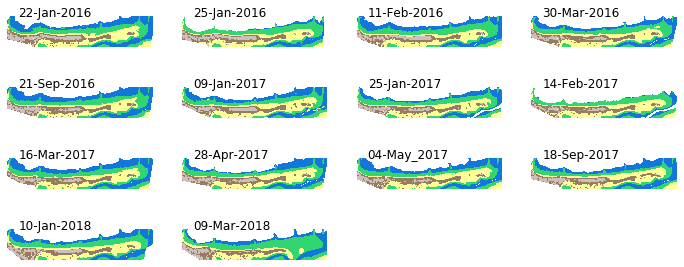

In [19]:
# declare a plot size
clevels = [-2,0,2,4,6,8]
fig  = plt.figure(figsize=(12,5))
for i in range(nf):
# small plots of elevation
    ax=fig.add_subplot(4,4,i+1)
    plt.axis('off')
    plt.contourf(xrot,yrot,np.squeeze(dsa[i,:,:].values),clevels,cmap=plt.cm.terrain)
    plt.text(100,270,titles[i],fontsize=12)
    ax.set_aspect(1.);

In [12]:
print(nf)

14
